# Showing Receptive Fields
Note: some of this content is adapted from the [Allen SDK](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

One of the most important features of visually responsive neurons is the location and extent of their *receptive field*. This is the region within the visual field in which stimulation can affect the neuron's response. Is it highly localized or spatially distributed? Is it centered on the stimulus display, or is it on an edge? How much does it overlap with the receptive fields of neurons in other regions? Obtaining answers to these questions is a crucial step for interpreting results related to neurons' visual coding properties. This notebook demonstrates how to use the 'gabors' stimulus table and the `Units` table to compute the receptive fields.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Download Ecephys File
 In this example, we use the Allen Institute's **Visual Coding - Neuropixels** dataset. Change the code to download the file you're interested in. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file, respectively. If you're accessing an embargoed dataset, and set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-716813540/sub-716813540_ses-739448407.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.62.2) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


### Reading Data
We need two components of data for this analysis; The `Units` table, which is discussed more in depth in [Visualizing Unit Quality Metrics](../visualization/visualize_unit_metrics.ipynb). In particular we need the `spike_times` property for the units. We also need the stimulus table from the NWB File's `Intervals` section. Because receptive field analysis is so central to interpreting results related to visual coding, experiments include some [Gabor patches](http://neuroanatody.com/2016/05/whats-in-a-gabor-patch/) which are used to reliably drive neural responses, shown repeatedly at a set of different coordinates within the mouse's visual field. This stimulus is usually shown at the beginning of the session, and typically uses the same parameters for every mouse. So for our purposes, we select the stimulus table named `gabors_presentations`. Below the `Units` table and the *gabors stimulus table* are shown.

In [5]:
units = nwb.units
units[:10]

,peak_channel_id,quality,waveform_halfwidth,amplitude,velocity_below,l_ratio,snr,amplitude_cutoff,spread,nn_miss_rate,...,isolation_distance,silhouette_score,velocity_above,cumulative_drift,firing_rate,waveform_duration,recovery_slope,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
951791104,850216277,good,0.247236,90.180675,-0.343384,1.383148e-02,0.763260,0.500000,100.0,0.004499,...,47.188066,0.104118,0.392438,418.06,2.341833,0.741709,-0.022793,"[3.2095355441515783, 6.124035954291701, 17.051...","[0.00010742085654993536, 0.0001035669805512930...","[[0.0, -0.3348150000001908, 10.006815000000017..."
951790926,850216277,noise,0.549414,96.975255,0.000000,2.362854e-01,0.676006,0.306994,140.0,0.009977,...,25.190298,0.029867,0.171692,392.19,2.613414,1.167504,-0.032515,"[2.7148354745354113, 3.1582355369324366, 3.193...","[9.173462781002884e-05, 8.000884789421282e-05,...","[[0.0, -5.414564999999925, 5.5407299999999395,..."
951790903,850216277,good,0.219765,244.056540,-0.686767,6.284489e-02,0.867047,0.500000,60.0,0.000905,...,30.063412,-0.036832,0.343384,483.90,0.744933,0.865327,-0.044864,"[1.6110686525422746, 2.9030355010196693, 2.907...","[0.00026998475697199466, 0.0002846940383350162...","[[0.0, -13.258049999999884, -18.07259999999988..."
951790894,850216277,good,0.164824,367.934580,-0.274707,3.215116e-05,3.188863,0.001455,70.0,0.000100,...,72.605985,0.005048,-0.343384,71.55,0.640379,0.824121,-0.033171,"[1281.742282131046, 1349.6264583506447, 1405.8...","[0.00025149672984953213, 0.0004496466043690103...","[[0.0, 0.71097000000006, -3.5579700000000116, ..."
951790884,850216277,good,0.329648,188.990015,0.537968,7.274902e-02,0.588863,0.074423,160.0,0.000000,...,24.436355,NaN,1.291776,0.00,0.034851,2.060302,NaN,"[7.834769528366286, 245.91720303227598, 438.41...","[9.431834274924923e-05, 0.00010953675617822429...","[[0.0, -13.237058823529424, -24.38345201238388..."
951790873,850216277,noise,1.249916,392.734333,1.041597,2.236291e-07,0.446848,0.500000,140.0,0.000000,...,94.253021,NaN,-0.196219,0.00,0.004855,1.565829,NaN,"[488.6720371937045, 1581.39612429953, 1760.856...","[0.00011043706542136272, 8.223885328261097e-05...","[[0.0, 15.990000000000009, 46.18466666666663, ..."
951790864,850216277,noise,1.318593,277.943055,6.364042,NaN,1.465630,0.011230,160.0,0.000000,...,NaN,-0.056607,-8.328692,1810.38,0.542730,2.225126,-4.514536,"[51.122208953280754, 65.47991097375385, 65.491...","[0.00017703212276047242, 0.0001768216167308391...","[[0.0, -1.7390099999999222, -5.484569999999962..."
951790850,850216277,noise,1.648241,189.359235,-0.457845,2.436327e-01,0.850077,0.172105,160.0,0.001341,...,16.992300,-0.070661,2.583553,999.03,0.765002,1.881742,-3.234939,"[51.113175618676216, 51.12444228692837, 62.794...","[0.00012096045820642862, 0.0001094972500522143...","[[0.0, -0.875939999999872, -4.936424999999701,..."
951790836,850216277,good,0.329648,106.165605,-0.529792,3.770473e-02,0.775795,0.500000,90.0,0.006340,...,36.216320,0.042926,-0.892797,280.11,2.340107,0.769179,-0.020140,"[0.6329351815620978, 0.6378018489136213, 1.041...","[0.0001462638799394556, 0.00011085512769588882...","[[0.0, 0.19090500000024235, -2.333954999999832..."


In [6]:
nwb.intervals.keys()

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])

In [7]:
rf_stim_table = nwb.intervals["gabors_presentations"].to_dataframe()
rf_stim_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,temporal_frequency,x_position,y_position,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,,,,
0,88.684670,88.918188,gabors,0.0,4.0,30.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,88.918188,89.168385,gabors,0.0,4.0,-20.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,89.168385,89.418582,gabors,0.0,4.0,-20.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,89.418582,89.668780,gabors,0.0,4.0,-20.0,40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,89.668780,89.918990,gabors,0.0,4.0,10.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,89.918990,90.169200,gabors,0.0,4.0,10.0,10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,90.169200,90.419410,gabors,0.0,4.0,-30.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,90.419410,90.669620,gabors,0.0,4.0,20.0,0.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,90.669620,90.919822,gabors,0.0,4.0,30.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(9, 1, timestamps pynwb.base.TimeSeries at 0x..."


### Selecting Units
It would be inconvenient to try to view and generate the receptive fields for all units at once. Below you can select units based on their quality metrics and the brain region they appear in. If you'd like, redefine the `select_condition` function to set different criteria for selecting the units you'd like to view. For more information on the useful metrics of units in the `Units` table, see [Visualizing Unit Quality Metrics](../visualization/visualize_unit_metrics.ipynb). Because it can be very useful to select units by brain region or by probe, you may use the `get_unit_location` and `get_unit_probe` functions below, which take information from the `Electrodes` table to get the location and probes for each unit respectively. The sets of probe names and location names are printed for your convenience.

In [8]:
### helper functions made from electrodes table to get brain location of unit or probe name of unit

# map channel ids to brain location and probe group name
# creates a dictionary that iterates over indices of the dataset, assigns "id" as the key, and makes the location the value
channel_locations = {nwb.electrodes["id"][i]: nwb.electrodes["location"][i] for i in range(len(nwb.electrodes))}
# creates similar dictionary as previous line, but with the group name/probe name as the value
channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}

# function retrieves peak channel ID for given unit index from "units" dataset and looks up corresponding probe from dictionary
def get_unit_location(unit_idx):
    peak_channel_id = units["peak_channel_id"][unit_idx]
    return channel_locations[peak_channel_id]

# function retrieves peak channel ID from "units" dataset, looks up corresponding group name, returns probe associated with peak channel
def get_unit_probe(unit_idx):
    peak_channel_id = units["peak_channel_id"][unit_idx]
    return channel_probes[peak_channel_id]

print(set(channel_locations.values()))
print(set(channel_probes.values()))

{'', 'VISp', 'VIS', 'VISl', 'grey', 'VISam', 'VISrl'}
{'probeD', 'probeE', 'probeC', 'probeA', 'probeF', 'probeB'}


In [9]:
### select units to view the receptive fields of, change the conditional function below to select different units

def select_condition(unit_idx):
    # the values below are recommended thresholds for these quality metrics
    return units["snr"][unit_idx] > 1 and \
            units["isi_violations"][unit_idx] < 1 and \
            units["firing_rate"][unit_idx] > 0.1 and \
            get_unit_location(unit_idx) == "VISam"
            # get_unit_probe(unit_idx) == "probeC"
            # change the line above an option above to select a different brain location or probe

selected_unit_idxs = []
for unit_idx in range(len(units)):
    if select_condition(unit_idx):
        selected_unit_idxs.append(unit_idx)
        
if len(selected_unit_idxs) == 0:
    raise IndexError("There are no units for this selection")

print(len(selected_unit_idxs))

111


### Getting Fields
Below the receptive fields for each selected unit are calculated and a visualization for each one is generated. First, we get the dimensions of the receptive field plots from the set of possible coordinates of the gabor patch stimulus. Next we identify how many spikes happen in response to every stimulus for each coordinate of each unit's receptive field. Finally, we plot each receptive field as a 2D array.

In [10]:
### get x and y coordinates of gabors displayed to build receptive field

xs = np.sort(list(set(rf_stim_table.x_position)))
ys = np.sort(list(set(rf_stim_table.y_position)))
field_units = rf_stim_table.units[0]
print(xs)
print(ys)
print(field_units)

[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
deg


In [11]:
### get receptive field of a unit using its spike times and the stim table

def get_rf(spike_times):
    # creates 2D array that stores response spike counts for each coordinate of the receptive field
    unit_rf = np.zeros([ys.size, xs.size])
    # for every x and y coordinate in the field
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            
            # for this coordinate of the rf, count all the times that this neuron responds to a stimulus time with a spike
            stim_times = rf_stim_table[(rf_stim_table.x_position == x) & (rf_stim_table.y_position == y)].start_time
            response_spike_count = 0
            for stim_time in stim_times:
                # any spike within 0.2 seconds after stim time is considered a response
                start_idx, end_idx = np.searchsorted(spike_times, [stim_time, stim_time+0.2])
                response_spike_count += end_idx-start_idx

            unit_rf[yi, xi] = response_spike_count
    
    return unit_rf

In [12]:
### compute receptive fields for each unit in selected units

unit_rfs = []
for unit_idx in selected_unit_idxs:
    unit_spike_times = units["spike_times"][unit_idx]
    unit_rfs.append(get_rf(unit_spike_times))

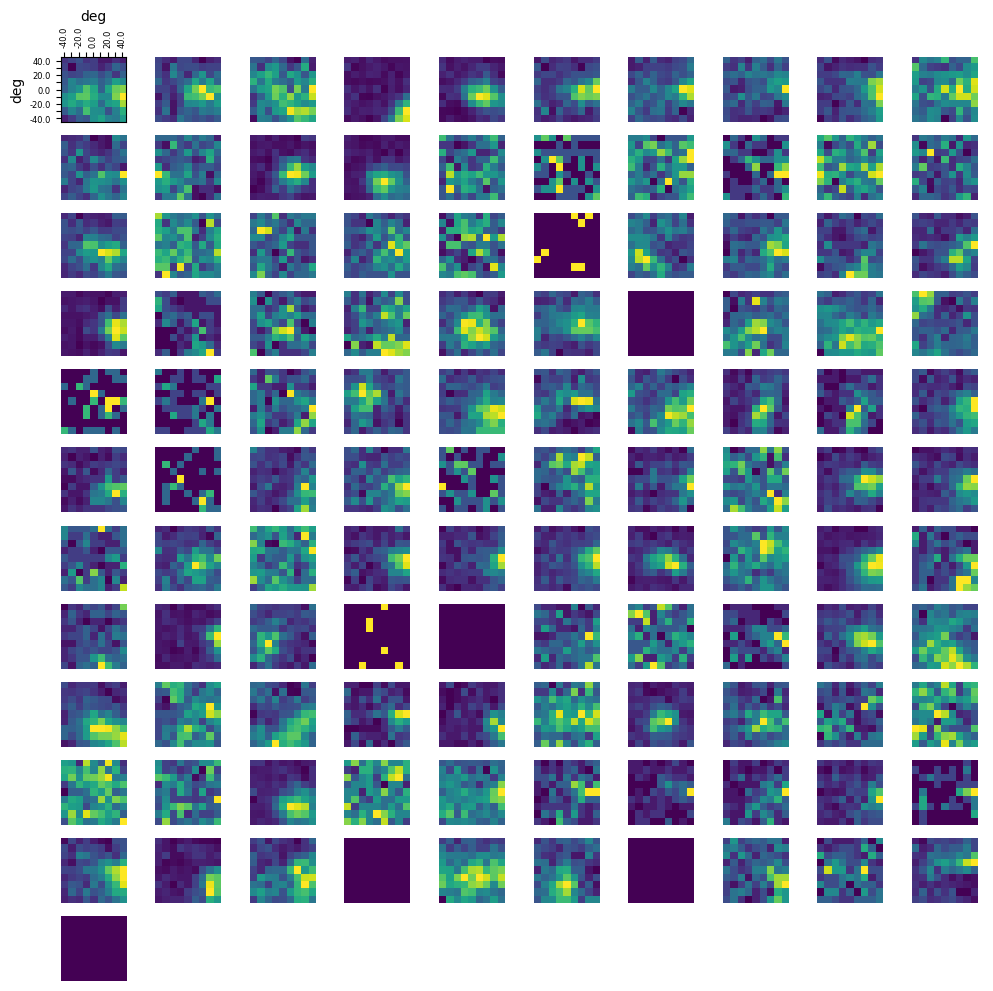

In [13]:
### display the receptive fields for each unit in a 2D plot

n_rows = len(unit_rfs)//10
fig, axes = plt.subplots(n_rows+1, 10)
fig.set_size_inches(12, n_rows+1)

# handle case where there's <= 10 rfs
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for irf, rf in enumerate(unit_rfs):
    ax_row = int(irf/10)
    ax_col = irf%10
    axes[ax_row][ax_col].imshow(rf, origin="lower")
for ax in axes.flat[1:]:
    ax.axis('off')

# making axis labels for first receptive field
axes[0][0].set_xlabel(field_units)
axes[0][0].set_ylabel(field_units)
axes[0][0].xaxis.set_label_position("top") 
axes[0][0].xaxis.set_ticks_position("top")
axes[0][0].set_xticks(range(len(xs)), xs, rotation=90, fontsize=6)
axes[0][0].set_yticks(range(len(ys)), ys, fontsize=6)

for i, l in enumerate(axes[0][0].xaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[0][0].yaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)